# Segmentation des clients par régression logistique

In [1]:
import pandas as pd
import numpy as np
import os
import s3fs
import re
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# # modification des variables categorielles
 
# ### variable gender
# df1_customer_product["gender_label"] = df1_customer_product["gender"].map({
#     0: 'female',
#     1: 'male',
#     2: 'other'
# })
 
# ### variable country -> on indique si le pays est france
# df1_customer_product["country_fr"] = df1_customer_product["country"].apply(lambda x : int(x=="fr") if pd.notna(x) else np.nan)

# # Création des indicatrices de gender
# gender_dummies = pd.get_dummies(df1_customer_product["gender_label"], prefix='gender').astype(int)
 
# # Concaténation des indicatrices avec le dataframe d'origine
# df1_customer_product = pd.concat([df1_customer_product, gender_dummies], axis=1)

In [3]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [4]:
# Importation des données
BUCKET = "projet-bdc2324-team1/1_Output/Logistique Regression databases - First approach"

FILE_PATH_S3 = BUCKET + "/" + "dataset_train.csv"

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    dataset_train = pd.read_csv(file_in, sep=",")

FILE_PATH_S3 = BUCKET + "/" + "dataset_test.csv"

with fs.open(FILE_PATH_S3, mode="rb") as file_in:
    dataset_test = pd.read_csv(file_in, sep=",")


/tmp/ipykernel_7388/1677066092.py:7: DtypeWarning: Columns (21,39) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_train = pd.read_csv(file_in, sep=",")
/tmp/ipykernel_7388/1677066092.py:12: DtypeWarning: Columns (21,39) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_test = pd.read_csv(file_in, sep=",")


In [5]:
dataset_train[['event_type_id', 'name_event_types']].drop_duplicates()

event_type_id          name_event_types
0            2.0  offre muséale individuel
1            4.0          spectacle vivant
2            5.0      offre muséale groupe
3            NaN                       NaN

In [6]:
#Choose type of event 
type_event_choosed = 5

dataset_test = dataset_test[(dataset_test['event_type_id'] == type_event_choosed) | np.isnan(dataset_test['event_type_id'])]
dataset_test['y_has_purchased'] = dataset_test['y_has_purchased'].fillna(0)
dataset_train = dataset_train[(dataset_train['event_type_id'] == type_event_choosed) | np.isnan(dataset_train['event_type_id'])]
dataset_train['y_has_purchased'] = dataset_train['y_has_purchased'].fillna(0)

In [8]:
dataset_train.isna().sum()/len(dataset_train)

customer_id               0.000000
event_type_id             0.984075
nb_tickets                0.000000
nb_purchases              0.000000
total_amount              0.000000
nb_suppliers              0.000000
vente_internet_max        0.000000
purchase_date_min         0.984075
purchase_date_max         0.984075
time_between_purchase     0.984075
nb_tickets_internet       0.000000
name_event_types          0.984075
avg_amount                0.984075
birthdate                 0.961026
street_id                 0.000000
is_partner                0.000000
gender                    0.000000
is_email_true             0.000000
opt_in                    0.000000
structure_id              0.869302
profession                0.950730
language                  0.991512
mcp_contact_id            0.276103
last_buying_date          0.633303
max_price                 0.633303
ticket_sum                0.000000
average_price             0.105825
fidelity                  0.000000
average_purchase_del

In [9]:

reg_columns = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'nb_tickets_internet', 'opt_in', 'fidelity', 'nb_campaigns', 'nb_campaigns_opened']

X_train = dataset_train[reg_columns]
y_train = dataset_train['y_has_purchased']
X_test = dataset_test[reg_columns]
y_test = dataset_test['y_has_purchased']

# Fit and transform the scaler on the training data
scaler = StandardScaler()

# Transform the test data using the same scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Create and fit the linear regression model
logit_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)
logit_model.fit(X_train_scaled, y_train)

y_pred = logit_model.predict(X_test_scaled)

#Evaluation du modèle 
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.9999434695179565
Confusion Matrix:
 [[123819      0]
 [     7      1]]
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    123819
         1.0       1.00      0.12      0.22         8

    accuracy                           1.00    123827
   macro avg       1.00      0.56      0.61    123827
weighted avg       1.00      1.00      1.00    123827



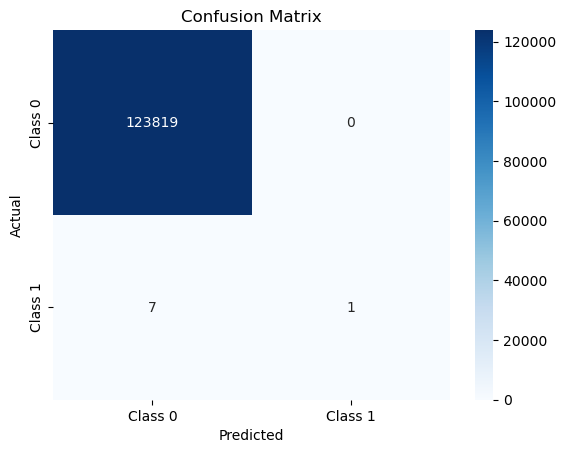

In [10]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()